In [1]:
#Basics
import pandas as pd
import numpy as np
import datetime as datetime
import random as random
import itertools

# Webscraping
import requests

# Models
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from statsmodels.graphics.tsaplots import plot_acf


# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(color_codes=True)
pal = sns.color_palette("Set2", 10)
sns.set_palette(pal)

In [2]:
## Goal 1: Download data from the web
##
## API call to pull history for top 10 currencies
base = "http://api.coingecko.com/api/v3"
url = base + "/coins/markets?vs_currency=USD&order=market_cap_desc"

## pull names of top 10 currencies
page = requests.get(url)
result_top = requests.get(url)
top = pd.DataFrame(result_top.json())

top_curr = top['id'][0:10]

## for loop for top 10 currencies
data = pd.DataFrame([])
df   = pd.DataFrame([])

for i in top_curr:
    url = (base + f'/coins/{i}/market_chart?vs_currency=USD&days=36')
    page = requests.get(url)
    result_hist = requests.get(url)
    data = pd.DataFrame(result_hist.json())
    
    # selecting columns for dataframe
    dates_unix = [x[0] for x in data['prices']]
    prices= [x[1] for x in data['prices']]
    market_caps= [x[1] for x in data['market_caps']]
    total_volumes= [x[1] for x in data['total_volumes']]
    data['name'] = i
    
    # creating df and append
    data= pd.DataFrame({
              'currency':i,
              'dates_unix':dates_unix,
              'prices': prices,
              'market_caps': market_caps,
              'total_volumes': total_volumes             
             })
    df=df.append(data,ignore_index=True)

In [3]:
# no warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
df.head(3)

,currency,dates_unix,prices,market_caps,total_volumes
0,bitcoin,1545318071247,4002.647377,6.977835e+10,5.561672e+09
1,bitcoin,1545321603727,3999.114304,6.973986e+10,5.838665e+09
2,bitcoin,1545325279552,4162.470546,7.256518e+10,6.269034e+09


In [5]:
## adding column with readable date 
df['dates_h'] = pd.to_datetime(df['dates_unix'],unit='ms').dt.round("H") #(rounded by hour)

##deleting all but 18th hours
df['18_hour'] = df.dates_h.dt.hour==18
df['dates_d'] = pd.to_datetime(df['dates_unix'],unit='ms').dt.round("d") # round up to day 
df = df[df['18_hour'] ==True]

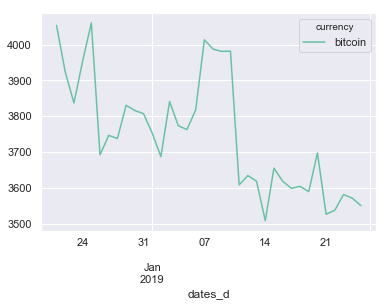

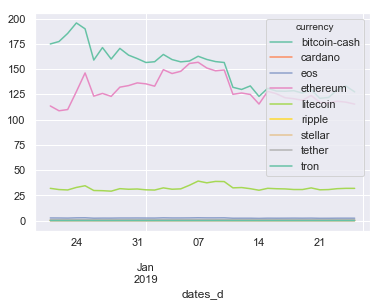

In [6]:
## Goal 2 (part a): Plot a time series
##
# Visualizing
df_bitcoin = df[df['currency'] =="bitcoin"]
df_top = df[df['currency'] !="bitcoin"]

df_bitcoin2 = pd.pivot_table(df_bitcoin, values='prices', columns='currency', index='dates_d', aggfunc=np.mean)
df_bitcoin2.plot.line()

df_top2 = pd.pivot_table(df_top, values='prices', columns='currency', index='dates_d', aggfunc=np.mean)
df_top2.plot.line()

In [7]:
## Adding a rolling mean of 24 hours as extra column
df['rolling'] = df.groupby(['currency'])['prices'].apply(lambda x:x.rolling(center=False,window=1).mean())
# export just for data checks
# df.to_csv('coin_mean6.csv', sep='\t', encoding='utf-8')

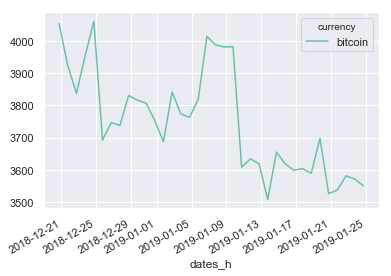

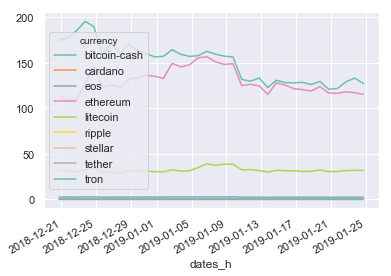

In [8]:
## Goal 2  (part b):  Plot a time series
df_bitcoin = df[df['currency'] =="bitcoin"]
df_top = df[df['currency'] !="bitcoin"]

df_bitcoin2 = pd.pivot_table(df_bitcoin, values='rolling', columns='currency', index='dates_h', aggfunc=np.mean)
df_bitcoin2.plot.line()


df_top2 = pd.pivot_table(df_top, values='rolling', columns='currency', index='dates_h', aggfunc=np.mean)
df_top2.plot.line()

In [9]:
## data for bitcoin only from hereon forward
df2 = df[df['currency'] == "bitcoin"]

In [10]:
df2 = df2[['dates_h','prices']]
df2.set_index(['dates_h'] , inplace=True)
df2.sort_index(inplace=True)

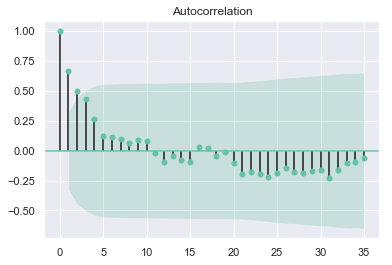

In [11]:
### Test for stationary
plot_acf(df2['prices']);
### results show its NOT stationary yet!

A time series has stationarity if a shift in time doesn’t cause a change in the shape of the distribution. 
Basic properties of the distribution like the mean , variance and covariance are constant over time.

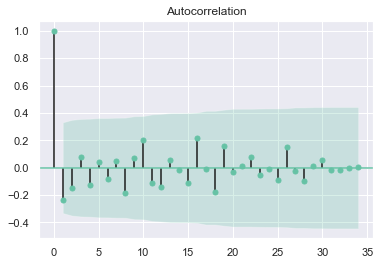

In [12]:
#create difference
df_train_diff = df2.diff(periods=1)
df_train_diff = df_train_diff[1:] # cut off first row with NaN
plot_acf(df_train_diff['prices']);
# now its stationary as it goes directly negative 

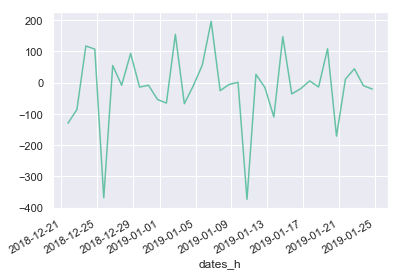

In [13]:
df_train_diff['prices'].plot()

In [14]:
X = df2.prices
X.size

36

In [15]:
train = X[:27] # 28 datapoints or 80 %
test  = X[26:] # 7 datapoints or 20%
predictions = []

### (Simple) Autoregressive AR Model
An autoregressive (AR) model predicts future behavior based on past behavior. It’s used for forecasting when there is some correlation between values in a time series and the values that precede and succeed them. You only use past data to model the behavior, hence the name autoregressive (the Greek prefix auto– means “self.” ). The process is basically a linear regression of the data in the current series against one or more past values in the same series.

In an AR model, the value of the outcome variable (Y) at some point t in time is — like “regular” linear regression — directly related to the predictor variable (X). Where simple linear regression and AR models differ is that Y is dependent on X and previous values for Y. 

In [16]:
model_ar = AR(train)
model_ar_fit = model_ar.fit()
predictions = model_ar_fit.predict(start=27, end=35)

C:\Users\steff\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


(array([737075., 737076., 737077., 737078., 737079., 737080., 737081.,
        737082., 737083., 737084.]), <a list of 10 Text xticklabel objects>)

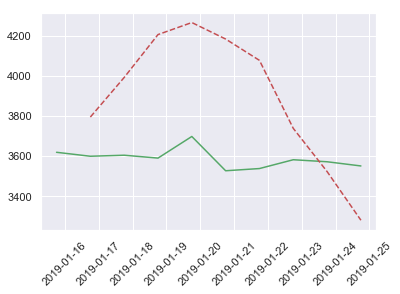

In [17]:
plt.plot(test ,  'g-')
plt.plot(predictions, 'r--')
plt.xticks(rotation=45)   

### ARIMA Model
ARIMA stands for Auto Regressive Integrated Moving Average. A nonseasonal ARIMA model is classified as an "ARIMA(p,d,q)" model, where:

    p is the number of periods taken for autoregression,
    d is the number of nonseasonal differences needed for stationarity (intergrated order), and
    q is the number of lagged forecast errors in the prediction equation. 

In [18]:
model_arima = ARIMA(train,order=(1, 2, 1))#pdq  
model_arima_fit = model_arima.fit()
model_arima_fit.aic

C:\Users\steff\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\steff\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


325.96415203005046

In [19]:
predictions = model_arima_fit.forecast(steps= 10)[0]
predictions

array([3613.48432425, 3603.66395931, 3595.32307063, 3587.28985217,
       3579.77325164, 3572.73601105, 3566.18477396, 3560.11835574,
       3554.53696763, 3549.44057197])

In [20]:
type(test),type(predictions)

(pandas.core.series.Series, numpy.ndarray)

In [21]:
test

dates_h
2019-01-15 18:00:00    3618.212524
2019-01-16 18:00:00    3598.464702
2019-01-17 18:00:00    3603.639240
2019-01-18 18:00:00    3589.211481
2019-01-19 18:00:00    3697.200168
2019-01-20 18:00:00    3525.951088
2019-01-21 18:00:00    3536.999443
2019-01-22 18:00:00    3581.010298
2019-01-23 18:00:00    3570.927863
2019-01-24 18:00:00    3549.951962
Name: prices, dtype: float64

In [22]:
df_test = pd.DataFrame({'dates_h': test.index,
                        'prices': test.values})
df_test['predictions'] = predictions
df_test

,dates_h,prices,predictions
0,2019-01-15 18:00:00,3618.212524,3613.484324
1,2019-01-16 18:00:00,3598.464702,3603.663959
2,2019-01-17 18:00:00,3603.639240,3595.323071
3,2019-01-18 18:00:00,3589.211481,3587.289852
4,2019-01-19 18:00:00,3697.200168,3579.773252
5,2019-01-20 18:00:00,3525.951088,3572.736011
6,2019-01-21 18:00:00,3536.999443,3566.184774
7,2019-01-22 18:00:00,3581.010298,3560.118356
8,2019-01-23 18:00:00,3570.927863,3554.536968
9,2019-01-24 18:00:00,3549.951962,3549.440572


In [23]:
df_test['dates'] = pd.to_datetime(df_test['dates_h'].dt.round("d"))- pd.DateOffset(days=1)

In [24]:
df_test.shape, len(predictions)

((10, 4), 10)

(array([737074., 737075., 737076., 737077., 737078., 737079., 737080.,
        737081., 737082., 737083.]), <a list of 10 Text xticklabel objects>)

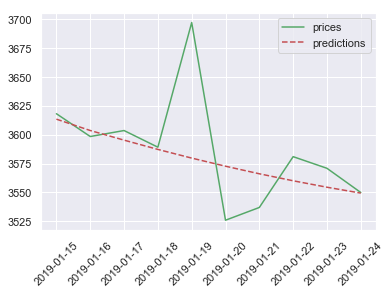

In [26]:
x = df_test['dates']
y1 = df_test['prices']
y2 = df_test['predictions']

plt.plot(x, y1,  'g-') 
plt.plot(x, y2, 'r--') 

plt.legend()
plt.xticks(rotation=45) 

In [27]:
predictions = model_arima_fit.forecast(steps= 12)[0]

In [28]:
# predicted price of bitcoin for Saturday and Sunday
print('Saturday: ' +str(predictions[-2:-1])),print('Sunday: ' +str(predictions[-1:]))

Saturday: [3544.82917546]
Sunday: [3540.70277691]


(None, None)

In [31]:
## adding two additional days in future
# In order to do this, we first need to create 2 dummy rows that we can attach onto our training data.
dummy_rows = pd.DataFrame(np.zeros(shape=(2,len(df_test.columns))),
                          columns=df_test.columns)

dummy_rows

,dates_h,prices,predictions,dates
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0


In [32]:
# Concatenate our known data with our dummy data.¶
df_test2 = pd.concat([df_test, dummy_rows])
df_test2.tail(5)

,dates_h,prices,predictions,dates
7,2019-01-22 18:00:00,3581.010298,3560.118356,2019-01-22 00:00:00
8,2019-01-23 18:00:00,3570.927863,3554.536968,2019-01-23 00:00:00
9,2019-01-24 18:00:00,3549.951962,3549.440572,2019-01-24 00:00:00
0,0,0.000000,0.000000,0
1,0,0.000000,0.000000,0


In [33]:
#Let's inspect our new TimeStamps
timestamps = df_test2['dates_h'].values
list(timestamps[-10:]) #show the last 10

[Timestamp('2019-01-17 18:00:00'),
 Timestamp('2019-01-18 18:00:00'),
 Timestamp('2019-01-19 18:00:00'),
 Timestamp('2019-01-20 18:00:00'),
 Timestamp('2019-01-21 18:00:00'),
 Timestamp('2019-01-22 18:00:00'),
 Timestamp('2019-01-23 18:00:00'),
 Timestamp('2019-01-24 18:00:00'),
 0.0,
 0.0]

In [34]:
#define current date
presentDay = timestamps[-3]
presentDay

Timestamp('2019-01-24 18:00:00')

In [40]:
df_test2.iat[-2, 0] = presentDay + pd.DateOffset(days=1)
df_test2.iat[-1, 0] = presentDay + pd.DateOffset(days=2)

df_test2.tail(3)

,dates_h,prices,predictions,dates
9,2019-01-24 18:00:00,3549.951962,3549.440572,2019-01-24
0,2019-01-25 18:00:00,NaN,3544.829175,2019-01-25
1,2019-01-26 18:00:00,NaN,3540.702777,2019-01-26


In [39]:
# adding prediction to joined dataframe
df_test2.iloc[-2:-1,2:3]=predictions[-2:-1]
df_test2.iloc[-1:,2:3]=predictions[-1:]
df_test2.iloc[-2:-1,-1:]=presentDay + pd.DateOffset( minutes=360)
df_test2.iloc[-1:,-1:]=presentDay + pd.DateOffset(days=1, minutes=360)
# overwriting 0 with null
df_test2.replace(0, np.nan, inplace=True)
df_test2.tail(3)

,dates_h,prices,predictions,dates
9,2019-01-24 18:00:00,3549.951962,3549.440572,2019-01-24
0,2019-01-25 18:00:00,NaN,3544.829175,2019-01-25
1,2019-01-26 18:00:00,NaN,3540.702777,2019-01-26


(array([737074., 737076., 737078., 737080., 737082., 737084.]),
 <a list of 6 Text xticklabel objects>)

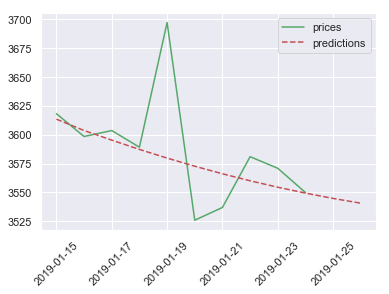

In [38]:
#Plotting prediction 
x = df_test2['dates']
y1 = df_test2['prices']
y2 = df_test2['predictions']

plt.plot(x, y1,  'g-') 
plt.plot(x, y2, 'r--') 

plt.legend()
plt.xticks(rotation=45) 

### Testing for best parameters in ARIMA

In [41]:
p=d=q=range(0,5)
pdq= list(itertools.product(p,d,q))
warnings.filterwarnings('ignore')
for param in pdq:
    try:
        model_arima = ARIMA(train,order=param) #pdq  
        model_arima_fit = model_arima.fit()
        print(param, model_arima_fit.aic)
    except:
        continue

(0, 0, 0) 350.59361263000613
(0, 0, 1) 344.1106097692661
(0, 0, 2) 344.97743052630153
(0, 0, 3) 345.1026844132149
(0, 0, 4) nan
(0, 1, 0) 331.126653033643
(0, 1, 1) 331.2696915724918
(0, 1, 2) 331.6188762729593
(0, 1, 3) 333.04720281963426
(0, 1, 4) 333.56330672950423
(0, 2, 0) 341.329581684716
(0, 2, 1) 324.75397860622684
(1, 0, 0) 341.57088491095533
(1, 0, 1) 343.5670079163712
(1, 0, 2) 345.56521926153545
(1, 0, 3) 347.1838505085055
(1, 1, 0) 331.94487964343506
(1, 1, 2) 332.274185698086
(1, 2, 0) 335.23377885400123
(1, 2, 1) 325.96415203005046
(1, 2, 2) 327.98656794194665
(1, 2, 3) 328.06829032043674
(2, 0, 0) 343.56719499947667
(2, 0, 1) 344.07696572794373
(2, 0, 3) 348.737249403861
(2, 1, 0) 332.7701939345738
(2, 1, 1) 334.0994346416697
(2, 2, 0) 331.5052760219975
(2, 2, 1) 327.21785999704025
(2, 2, 2) 328.2037567521039
(2, 2, 3) 329.1454126362132
(3, 0, 0) 345.5572011566701
(3, 0, 1) 346.45730380581074
(3, 0, 2) 347.3793915939231
(3, 1, 0) 334.7701551927403
(3, 1, 1) 334.23884250